In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("odedata.txt")
t = data[:, 0]
x = data[:, 1]
y = data[:, 2]

plt.plot(t, x, label="x(t)")
plt.plot(t, y, label="y(t)")
plt.xlabel("t")
plt.legend()
print(len(t))

C:\Users\romrellb\AppData\Local\Temp\ipykernel_26244\2677728454.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32).flatten()
 96%|█████████▌| 480/499.0 [08:01<00:19,  1.00s/it]


Text(0, 0.5, 'loss')

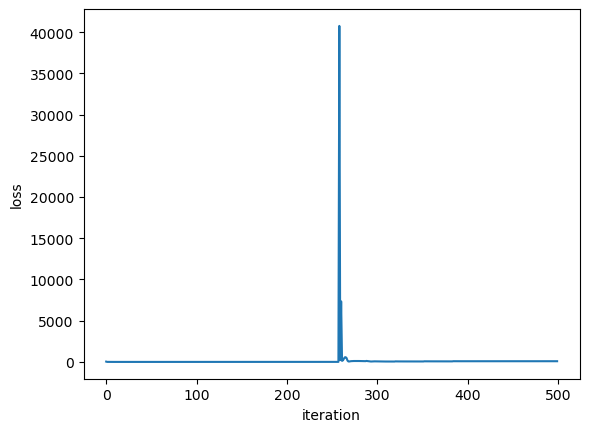

In [32]:
import torch
import torch.nn as nn
import torchdiffeq
import tqdm


class net(nn.Module):
    def __init__(
        self, input_dim, hidden_dims, output_dim, activation=nn.LeakyReLU
    ):
        super(net, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(activation())
        for i in range(1, len(hidden_dims)):
            layers.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
            layers.append(activation())
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, t, x0):
        return self.net(x0)


class ODE(nn.Module):
    def __init__(
        self, input_dim, hidden_dims, output_dim, activation=nn.LeakyReLU
    ):
        super(ODE, self).__init__()
        self.net = net(input_dim, hidden_dims, output_dim, activation)

    def forward(self, t, x0):
        return torchdiffeq.odeint(self.net, x0, t)


model = ODE(2, [32, 32], 2, activation=nn.SiLU)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

t = torch.tensor(t, dtype=torch.float32).flatten()
x = torch.tensor(data[:, 1:], dtype=torch.float32)
x0 = x[0]

# send to GPU
model = model.cuda()
t = t.cuda()
x = x.cuda()
x0 = x0.cuda()

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
losses = []
repeat = 32
tq = tqdm.tqdm(total=(len(t) - 2) / 64 * repeat)
model.train()
for i in range(64, len(t), 64):
    for param_group in optimizer.param_groups:
        param_group["lr"] = 0.01
    for _ in range(repeat):
        optimizer.zero_grad()
        x_pred = model(t[:i], x0)
        loss = criterion(x_pred, x[:i])
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        scheduler.step()
        tq.update(1)
tq.close()
for _ in range(20):
    optimizer.zero_grad()
    x_pred = model(t, x0)
    loss = criterion(x_pred, x)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.figure()
plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("loss")


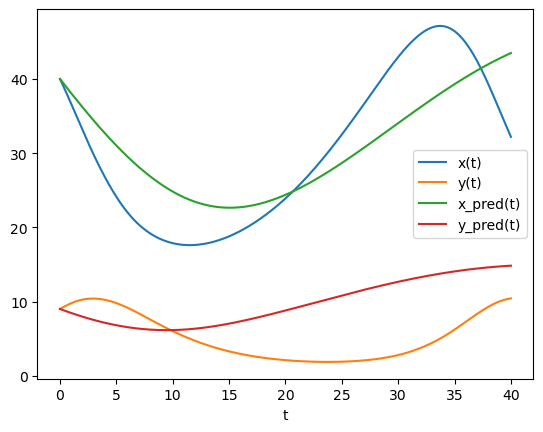

In [31]:
model = model.cpu()
t = t.cpu()
x = x.cpu()
x0 = x0.cpu()

model.eval()
pred = model(t, x0).detach().cpu().numpy()

plt.figure()
plt.plot(t, x[:, 0], label="x(t)")
plt.plot(t, x[:, 1], label="y(t)")
plt.plot(t, pred[:, 0], label="x_pred(t)")
plt.plot(t, pred[:, 1], label="y_pred(t)")
plt.xlabel("t")
plt.legend()
plt.show()
